In [4]:
from imports import *

**load data**

In [5]:
# Leer el archivo Parquet
table_loaded = pq.read_table("6'_20ophits.parquet")

# Convertir de vuelta a Awkward Array o NumPy
input = ak.to_numpy(table_loaded["input"])
nuvT_c = ak.to_numpy(table_loaded["nuvT_c"])

print("Loaded matrix shape:", input.shape)  # Debería ser (21900, 400, 4)
print("Loaded vector shape:",nuvT_c.shape)  # Debería ser (21900,))
print("Matrix sample:\n", input[0, :3])
print("Vector sample:", nuvT_c[:3])

Loaded matrix shape: (21964, 80, 4)
Loaded vector shape: (21964,)
Matrix sample:
 [[1478.72460015   70.            0.            0.        ]
 [1480.72460015   16.            0.            0.        ]
 [1480.72460015   14.            0.            0.        ]]
Vector sample: [1462.42688725 1480.24647869  643.02543649]


In [6]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(input, nuvT_c, test_size=0.2, random_state=42)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Modelo clásico**

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, ELU
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Mask is True where we want to KEEP the data (not -1000 in all features)
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

# Define the model with functional API
inputs = Input(shape=(80,4))
masked_inputs, mask = MaskNegative1000()(inputs)

lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1)

x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)
x = LeakyReLU(alpha=0.1)(x)  # Aplicando LeakyReLU
x = Dropout(0.3)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 80, 4)]      0           []                               
                                                                                                  
 mask_negative1000_3 (MaskNegat  ((None, 80, 4),     0           ['input_4[0][0]']                
 ive1000)                        (None, 80))                                                      
                                                                                                  
 lstm_6 (LSTM)                  (None, 80, 256)      267264      ['mask_negative1000_3[0][0]',    
                                                                  'mask_negative1000_3[0][1]']    
                                                                                            

**Modo Boosted**

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, Masking, Attention
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Creamos la máscara para valores que no sean -1000
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        mask = tf.cast(mask, dtype=tf.float32)  # Convertimos la máscara a float32 para su uso en la red
        # Aplicamos la máscara multiplicando por los datos
        return inputs * tf.expand_dims(mask, -1), mask

def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    masked_inputs, mask = MaskNegative1000()(inputs)

    # LSTM y capas adicionales
    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=True)(lstm_out1, mask=mask)
    lstm_out3 = LSTM(64, return_sequences=True)(lstm_out2, mask=mask)

    # Atención sobre sí mismo (self-attention)
    attn_out = Attention()([lstm_out3, lstm_out3])  # Se pasa lstm_out3 como consulta y valor

    lstm_out4 = LSTM(32, return_sequences=False)(attn_out, mask=mask)

    # Capas finales
    x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out4)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    # Crear el modelo
    model = Model(inputs, outputs)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, Attention
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Crear la máscara booleana para valores distintos de -1000
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        # No convertir a float32, dejarla como bool
        return inputs * tf.expand_dims(tf.cast(mask, dtype=tf.float32), -1), mask  # Datos en float32, máscara en bool
    
    def compute_mask(self, inputs, mask=None):
        return tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)

def create_model_vdef(input_shape):
    inputs = Input(shape=input_shape)
    
    masked_inputs, mask = MaskNegative1000()(inputs)

    # LSTM y capas adicionales
    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=True)(lstm_out1, mask=mask)
    lstm_out3 = LSTM(64, return_sequences=True)(lstm_out2, mask=mask)

    # Atención sobre sí mismo (self-attention)
    attn_out = Attention()([lstm_out3, lstm_out3])

    lstm_out4 = LSTM(32, return_sequences=False)(attn_out, mask=mask)

    # Capas finales
    x = Dense(64, kernel_regularizer=l2(0.001))(lstm_out4)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    # Crear el modelo
    model = Model(inputs, outputs)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


**GRU**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, GlobalAveragePooling1D, Layer
from tensorflow.keras.regularizers import l2

# Capa personalizada para enmascarar -1000
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return tf.where(mask[..., tf.newaxis], inputs, 0.0)  # Reemplaza -1000 con 0 donde sea necesario

# Modelo simplificado
inputs = Input(shape=(20, 4))  # 20 timesteps, 4 características
masked_inputs = MaskNegative1000()(inputs)

# Capa GRU para capturar dependencias temporales (simple pero efectiva)
x = GRU(32, return_sequences=False)(masked_inputs)  # 32 unidades, salida directa sin secuencias
x = Dropout(0.2)(x)  # Reducimos el dropout para permitir más aprendizaje
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)  # Capa densa con regularización leve
outputs = Dense(1)(x)  # Salida para regresión

# Construir y compilar el modelo
model_simple = Model(inputs, outputs)
model_simple.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_simple.summary()

**Tranformers**

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer, MultiHeadAttention, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.regularizers import l2

# Capa personalizada para enmascarar -1000
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return tf.where(mask[..., tf.newaxis], inputs, 0.0)  # Reemplaza -1000 con 0 donde sea necesario

# Capa de codificación posicional
class PositionalEncoding(Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_len = max_len
        self.d_model = d_model

    def call(self, inputs):
        position = tf.cast(tf.range(0, self.max_len, delta=1), tf.float32)
        position = tf.reshape(position, (-1, 1))
        div_term = tf.exp(tf.cast(tf.range(0, self.d_model, 2), tf.float32) * -(tf.math.log(10000.0) / self.d_model))
        
        # Cálculo de la codificación posicional
        pos_encoding = tf.zeros([self.max_len, self.d_model], dtype=tf.float32)
        pos_encoding = tf.tensor_scatter_nd_update(pos_encoding, 
                                                   [[i, j] for i in range(self.max_len) for j in range(0, self.d_model, 2)],
                                                   tf.reshape(tf.sin(position * div_term), [-1]))
        pos_encoding = tf.tensor_scatter_nd_update(pos_encoding, 
                                                   [[i, j] for i in range(self.max_len) for j in range(1, self.d_model, 2)],
                                                   tf.reshape(tf.cos(position * div_term), [-1]))
        pos_encoding = tf.expand_dims(pos_encoding, 0)
        return inputs + pos_encoding
    
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "max_len": self.max_len,
            "d_model": self.d_model
        })
        return config

# Bloque Transformer
def transformer_block(inputs, d_model, num_heads, ff_units, dropout_rate):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    ff_output = Dense(ff_units, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(d_model)(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(attention_output + ff_output)
    
    return ff_output

# Modelo complejo Transformer
inputs = Input(shape=(400, 4))  # 400 timesteps, 4 características
masked_inputs = MaskNegative1000()(inputs)

# Proyectamos las 4 características a d_model=64 antes de la codificación posicional
projected_inputs = Dense(64)(masked_inputs)  # Proyección a d_model=64
pos_encoding = PositionalEncoding(max_len=400, d_model=64)(projected_inputs)  # Ahora las dimensiones coinciden

# Apilamos más bloques Transformer con más cabezas de atención y mayor dimensionalidad
x = transformer_block(pos_encoding, d_model=64, num_heads=8, ff_units=128, dropout_rate=0.3)
x = transformer_block(x, d_model=64, num_heads=8, ff_units=128, dropout_rate=0.3)
x = transformer_block(x, d_model=64, num_heads=8, ff_units=128, dropout_rate=0.3)  # Se agrega un tercer bloque

# Agregar GlobalAveragePooling para reducir la dimensionalidad
x = GlobalAveragePooling1D()(x)

# Capa densa con mayor regularización L2 y mayor capacidad
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)  # Salida para regresión

# Construir y compilar el modelo
model_complex_transformer = Model(inputs, outputs)
model_complex_transformer.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_complex_transformer.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 400, 4)]     0           []                               
                                                                                                  
 mask_negative1000_19 (MaskNega  (None, 400, 4)      0           ['input_20[0][0]']               
 tive1000)                                                                                        
                                                                                                  
 dense_52 (Dense)               (None, 400, 64)      320         ['mask_negative1000_19[0][0]']   
                                                                                                  
 positional_encoding_9 (Positio  (None, 400, 64)     0           ['dense_52[0][0]']         

In [15]:
# Crear el modelo con una entrada de 20 pasos y 4 características
model2 = create_model_grok(input_shape=(20, 4))

# Mostrar el resumen del modelo
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 4)]      0           []                               
                                                                                                  
 mask_negative1000_2 (MaskNegat  ((None, 20, 4),     0           ['input_3[0][0]']                
 ive1000)                        (None, 20))                                                      
                                                                                                  
 lstm_5 (LSTM)                  (None, 20, 256)      267264      ['mask_negative1000_2[0][0]',    
                                                                  'mask_negative1000_2[0][1]']    
                                                                                            

In [13]:
y_pred, history= train_and_predict(model, X_train, y_train, X_temp, y_temp, epochs=80, batch_size=16)

Epoch 1/80
1099/1099 [==============================] - 24s 15ms/step - loss: 136442.8594 - mae: 217.4826 - val_loss: 7437.8047 - val_mae: 62.4077 - lr: 0.0010
Epoch 2/80
1099/1099 [==============================] - 14s 12ms/step - loss: 14623.9863 - mae: 81.8079 - val_loss: 4038.7781 - val_mae: 36.5128 - lr: 0.0010
Epoch 3/80
1099/1099 [==============================] - 15s 14ms/step - loss: 13446.9092 - mae: 77.0633 - val_loss: 4486.6284 - val_mae: 40.3495 - lr: 0.0010
Epoch 4/80
1099/1099 [==============================] - 14s 13ms/step - loss: 12349.2422 - mae: 73.7297 - val_loss: 6300.4634 - val_mae: 50.6462 - lr: 0.0010
Epoch 5/80
1099/1099 [==============================] - 14s 13ms/step - loss: 11226.3457 - mae: 69.7824 - val_loss: 4395.1924 - val_mae: 41.8242 - lr: 0.0010
Epoch 6/80
1096/1099 [============================>.] - ETA: 0s - loss: 11092.3721 - mae: 69.5130
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1099/1099 [===================

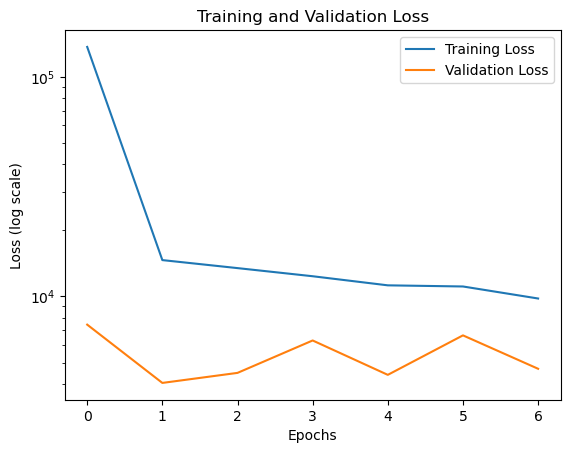

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


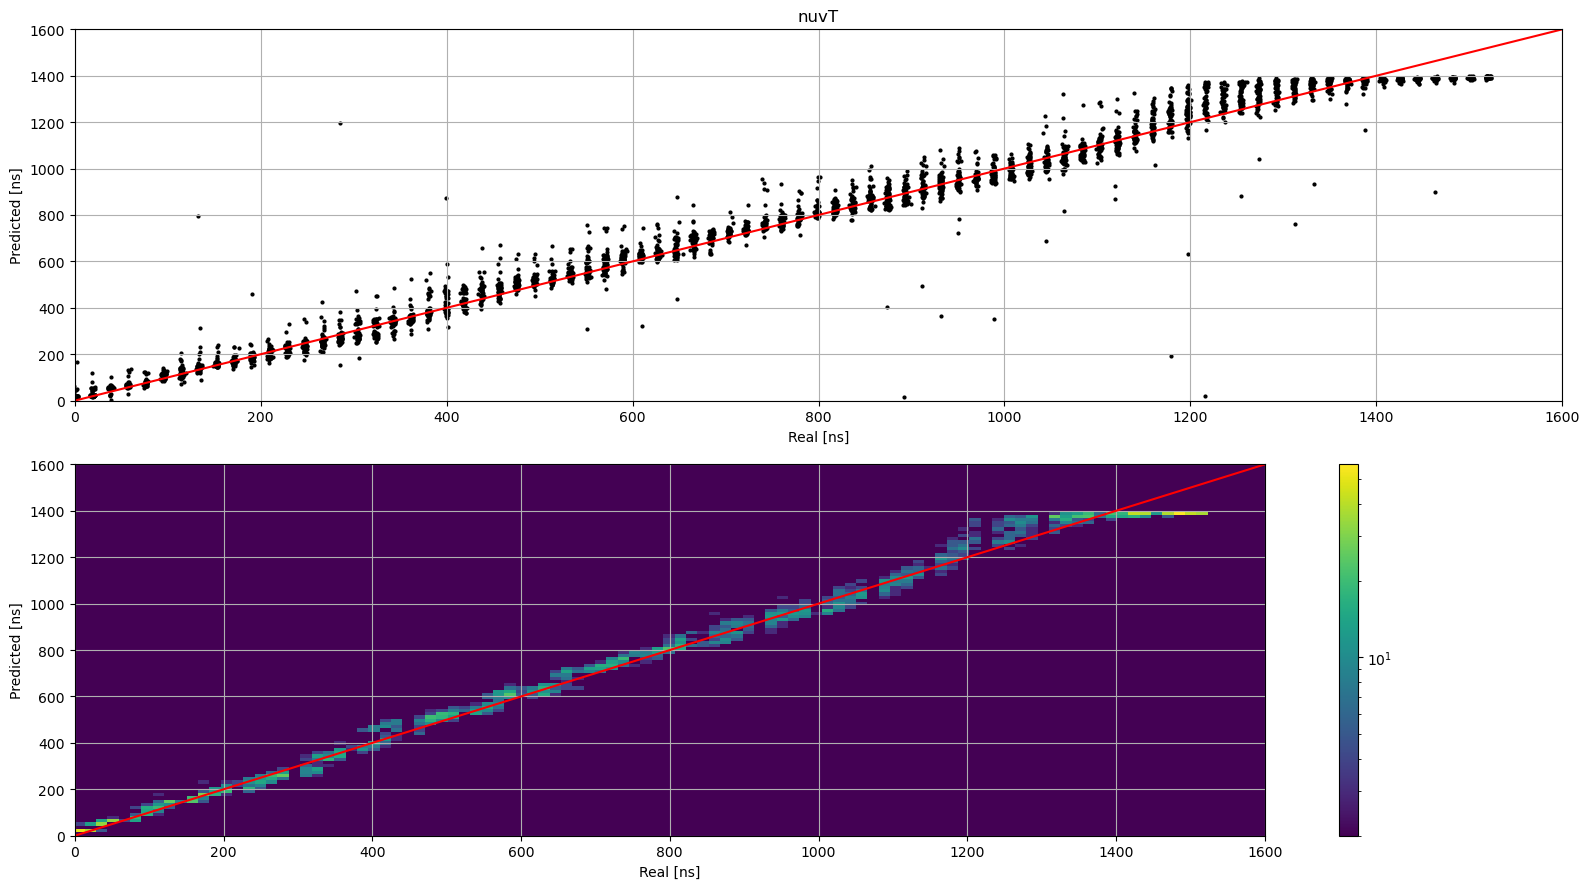

In [15]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,1,figsize=(16,9))

axs[0].scatter(y_temp, y_pred, color="black",s=4)
axs[0].grid()

axs[0].plot([0,1600],[0,1600],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1600])
axs[0].set_ylim([0,1600])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

im0 = axs[1].hist2d(y_temp, y_pred.flatten(), bins=(100, 100), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1600],[0,1600],'r')
axs[1].set_xlim([0,1600])
axs[1].set_ylim([0,1600])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')



fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

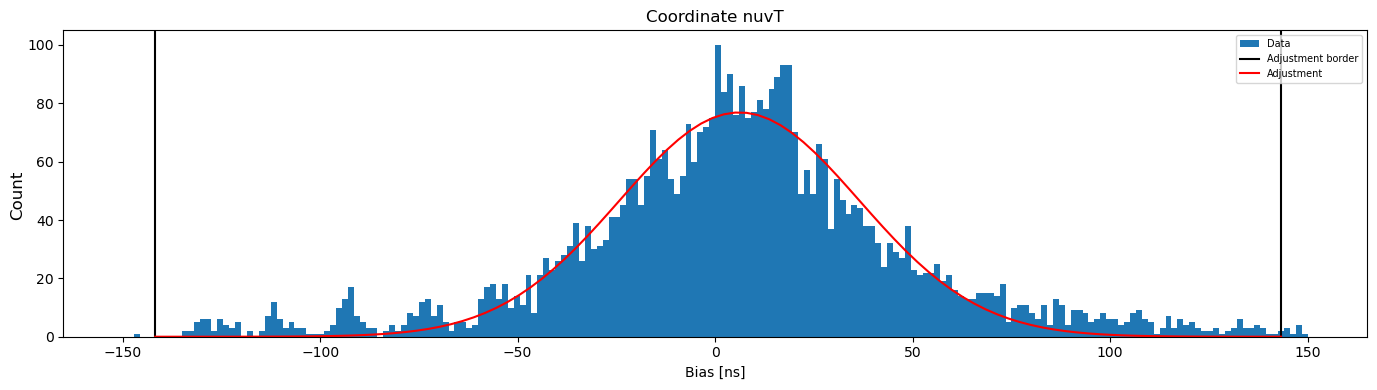

Bias Adjustment variables
------------------
Mean nuvT = 6.14
Sigma nuvT = 30.39
------------------


In [16]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = ak.flatten(y_pred) - y_temp

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, ax, coord_name, ini, fin, hist_range):
    counts, bins, patches = ax.hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    ax.axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    ax.axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    ax.plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    ax.set_xlabel('Bias [ns]')  # Set different xlabel for nuvT
    ax.set_title(f'Coordinate {coord_name}')
    ax.legend(prop={"size": 7})

    return popt

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(14, 4))

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, ax, 'nuvT', 5, 195, hist_range=[-150, 150])

# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')


### Explicabilidad - LIME

In [3]:
!pip install lime

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 24.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 5.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 4.3 MB/s eta 0:00:0000:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=1ea6dac151c03bf470c83ac1dd20c7e719336152338ded2acdfe95247228af6f
  Stored in directory: /home/vidales/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [23]:
print(X_train.shape[0])

17571


In [27]:
print(X_train[10].shape)

(80, 4)


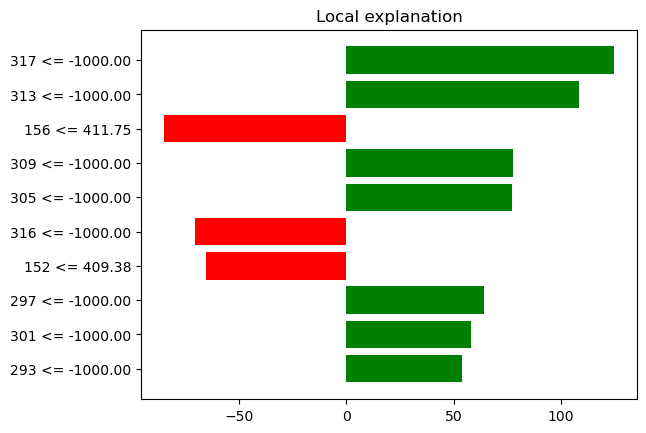

In [29]:
import numpy as np
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import tensorflow as tf



# Seleccionar una muestra para explicarla
sample_idx = 10  # Por ejemplo, seleccionamos la 10ª muestra de X_train
sample_data = X_train[sample_idx].reshape(1, 80, 4)

# Crear el explicador LIME
explainer = LimeTabularExplainer(
    training_data=X_train.reshape(X_train.shape[0], 80*4),  # Reestructuramos la entrada para LIME a (X_train.shape[0], 320)
    mode='regression',  # Esto es un modelo de regresión
    training_labels=y_train,
    discretize_continuous=True
)

# Definir la función para hacer las predicciones con el modelo
def model_predict(x):
    x = x.reshape(-1, 80, 4)  # Reshape para que sea compatible con el modelo LSTM
    return model.predict(x)

# Explicar la predicción de la muestra seleccionada
explanation = explainer.explain_instance(
    sample_data.reshape(80*4),  # Reestructuramos la muestra seleccionada a (320)
    model_predict, 
    num_features=10,  # Mostrar las 10 características más importantes
)

# Visualizar la explicación
explanation.show_in_notebook(show_table=True, show_all=False)

# También puedes graficar la importancia de cada característica
explanation.as_pyplot_figure()
plt.show()
